# Building a Song Recommendation System with Spotify

This dataset is based on the subset of users in the #nowplaying dataset who publish their #nowplaying tweets via Spotify.

In principle, the dataset holds users, their playlists and the tracks contained in these playlists.

Have downloaded this dataset from www.kaggle.com

## Introduction:

A recommendation system or recommendation engine is a model used for information filtering where it tries to predict the preferences of a user and provide suggests based on these preferences. These systems have become increasingly popular nowadays and are widely used today in areas such as movies, music, books, videos, clothing, restaurants, food, places and other utilities. These systems collect information about a user's preferences and behaviour, and then use this information to improve their suggestions in the future.

Spotify does a great job of recommending tracks via both daily mixes and track radios, but how do we build something like this ourselves? The aim here was to use machine learning and recommender system techniques to recommend new tracks based on tracks in my favourite playlists.

## Problem Statement:

This project’s goal is to provide automatic playlist continuation which would enable any music platform (here Spotify) to seamlessly support their users in creating and expanding the playlists by making recommendations based on their choices and preferences.

Also, developing a Spotify playlist builder with a songs recommender using k-means algorithm.

#### Popularity Recommending systems:

A popularity recommender recommends songs ranked by their popularity regardless of user’s preferences. This is of course dependent upon the methodology used to determine the popularity metric (usually some function of time, user interactions, and user ratings).

#### Collaborative filtering systems:

Analyse the user's behaviour and preferences and predict what they would like based on similarity with other users. There are two kinds of collaborative filtering systems.

* user-based recommender and item-based recommender.

User-based preferences are very common in the field of designing personalized systems. This approach is based on the user's likings. The process starts with users giving ratings (1-5) to some songs. These ratings can be implicit or explicit. Explicit ratings are when the user explicitly rates the item on some scale or indicates a thumbs-up/thumbs-down to the item.

#### K-means:

Is a centroid-based clustering algorithm that follows a simple procedure of classifying a given dataset into a pre-determined number of clusters, denoted as “k”. 

# Building a Song Recommendation System with Spotify

## File descriptions:

spotify_dataset.csv - data set

## Structure:

* Data Import
* Exploratory Data Analysis
* Visualization
* Explore most played tracks, artists, playlists and their graph associations
* Recommendation engine
* Clustering 
* Matrix Factorization
* Conclusion 

## Import Libraries:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
import pickle

from scipy import sparse
import re

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
                    
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

## Read Data:

In [2]:
# Show data to get an idea of the data:

data = pd.read_csv('spotify_dataset.csv', error_bad_lines = False, warn_bad_lines = False, skiprows = lambda x: x > 0 and random.random() > 0.05)
data.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Lissie,Here Before,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Crowded House,Nobody Wants To,HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Joe Echo,This Is The World We Live In,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Tom Petty And The Heartbreakers,American Girl,IOW 2012
4,9cc0cfd4d7d7885102480dd99e7a90d6,Miles Kane,First of My Kind,IOW 2012


## Exploratory Data Analysis:

In [3]:
# Replace column names:

data.columns = data.columns.str.replace('"', ' ')
data.columns = data.columns.str.replace('name', ' ')
data.columns = data.columns.str.replace('_id', ' ')
data.columns = data.columns.str.replace(' ', '')

In [4]:
# No of rows and columns:

data.shape

(644456, 4)

In [5]:
# Summary statistics:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644456 entries, 0 to 644455
Data columns (total 4 columns):
user        644456 non-null object
artist      642793 non-null object
track       644453 non-null object
playlist    644402 non-null object
dtypes: object(4)
memory usage: 19.7+ MB


In [6]:
# Summary statistics:

data.describe(include = 'all')

,user,artist,track,playlist
count,644456,642793,644453,644402
unique,14511,77889,305608,100639
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,14931,1845,350,66804


In [7]:
# Find and explore null values:

data.isnull().sum()

user           0
artist      1663
track          3
playlist      54
dtype: int64

In [8]:
# Find and explore duplicates:

data.duplicated().sum()

0

### Visualization:

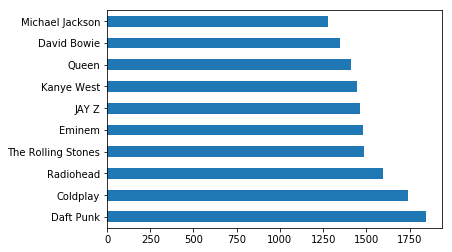

In [9]:
# Top artists:

data['artist'].value_counts()[:10].plot(kind = 'barh');

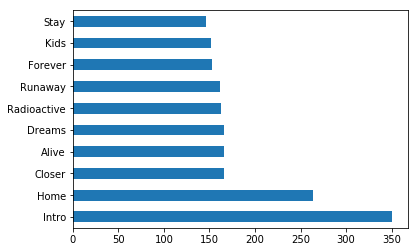

In [10]:
# Top tracks

data['track'].value_counts()[:10].plot(kind = 'barh');

In [11]:
# Converting string columns to int for future analysis:

def mapper(col):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in data[col]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1
        
        encoded.append(coded_dict[val])
    return encoded

artist_id = mapper('artist')
user_ids = mapper('user')


data['artist_id'] = artist_id
data['user_id'] = user_ids


# show header
data.head()

,user,artist,track,playlist,artist_id,user_id
0,9cc0cfd4d7d7885102480dd99e7a90d6,Lissie,Here Before,HARD ROCK 2010,1,1
1,9cc0cfd4d7d7885102480dd99e7a90d6,Crowded House,Nobody Wants To,HARD ROCK 2010,2,1
2,9cc0cfd4d7d7885102480dd99e7a90d6,Joe Echo,This Is The World We Live In,HARD ROCK 2010,3,1
3,9cc0cfd4d7d7885102480dd99e7a90d6,Tom Petty And The Heartbreakers,American Girl,IOW 2012,4,1
4,9cc0cfd4d7d7885102480dd99e7a90d6,Miles Kane,First of My Kind,IOW 2012,5,1


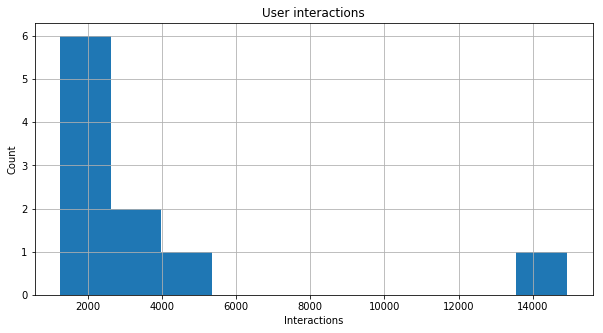

In [12]:
# Top users interaction with artists:

plt.figure(figsize = (10,5))

interaction = data.groupby(['user_id'])['artist'].count().sort_values(ascending = False)[:10]
interaction.hist()
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.title('User interactions');

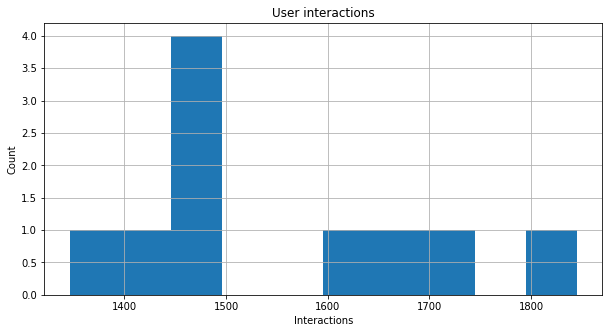

In [13]:
# Top artists tracks:

plt.figure(figsize = (10,5))

interaction = data.groupby(['artist_id'])['track'].count().sort_values(ascending = False)[:10]
interaction.hist()
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.title('User interactions');

In [14]:
# The most listened songs from the artist:

most_listened_artist_id = str(data.groupby('artist').count()['playlist'].sort_values(ascending = False).index[0]) 
max_views = data.groupby('artist_id').count()['playlist'].max() 

print('most_listened_artist:', most_listened_artist_id)
print('maximum_views :', max_views)

most_listened_artist: Daft Punk
maximum_views : 1845


#  Recommendations:

## Rank-Based Recommendations:

#### Top playlist:

In [15]:
# Top playlist:

def top_playlist(num, data = data):
    top = data.groupby(['playlist'])['artist_id'].count().sort_values(ascending = False)[:num]
    return top

top = top_playlist(35)

                    play  listeners
0                Starred      66804
1       Liked from Radio       9045
2                   Rock       1527
3  Favoritas de la radio       1526
4                   2014       1133


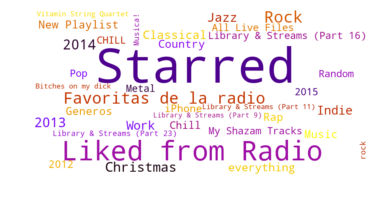

In [16]:
# Plot:

d = pd.DataFrame(top).reset_index()

d.columns = ['play', 'listeners']

print(d.head())
d_dict = d.set_index('play').to_dict()['listeners']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100,
                   random_state = 1).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Top tracks:

In [17]:
# Top tracks:

def top_tracks(num, data = data):
    top = data.groupby(['track'])['artist_id'].count().sort_values(ascending = False)[:num]
    return top

top = top_tracks(25)

    track  listeners
0   Intro        350
1    Home        264
2   Alive        166
3  Closer        166
4  Dreams        166


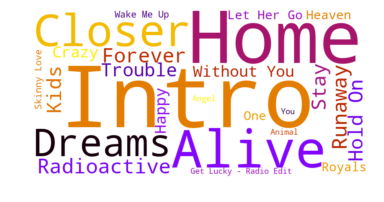

In [18]:
# Plot:

d = pd.DataFrame(top).reset_index()

d.columns = ['track', 'listeners']

print(d.head())
d_dict = d.set_index('track').to_dict()['listeners']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100,
                   random_state = 1).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Top artists:

In [19]:
# Top artists:

def top_artists(num, data = data):
    top = data.groupby(['artist'])['playlist'].count().sort_values(ascending = False)[:num]
    return top

top = top_artists(25)

               artist  plays
0           Daft Punk   1845
1            Coldplay   1741
2           Radiohead   1598
3  The Rolling Stones   1488
4              Eminem   1480


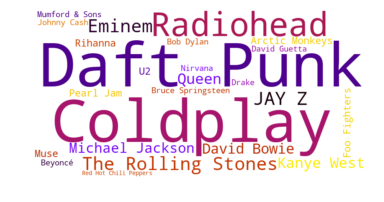

In [20]:
# Plot:

d = pd.DataFrame(top).reset_index()

d.columns = ['artist', 'plays']

print(d.head())
d_dict = d.set_index('artist').to_dict()['plays']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100,
                   random_state = 1).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

##  User-User Based Collaborative Filtering:

#### user_artist_matrix:

In [21]:
# Create user-artist matrix:

def create_user_artist_matrix(data):
    
    data['interact'] = 1
    data['interact'].apply(lambda ele: 1)
    user_artist = data.groupby(['user_id', 'artist_id'])['interact'].max().unstack().fillna(0).astype('int')
    
    return user_artist

user_artist = create_user_artist_matrix(data)

In [22]:
user_artist.head()

artist_id,1,2,3,4,5,6,7,8,9,10,...,77881,77882,77883,77884,77885,77886,77887,77888,77889,77890
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Top 10  similar users to the particular user:

In [23]:
def find_similar_users(user_id, user_artist = user_artist):
    
    # compute similarity of each user to the provided user:
    similarity_users = np.dot(user_artist[user_id - 1: user_id], user_artist.transpose())
    similarity_users = pd.DataFrame(similarity_users)
    similarity_users = similarity_users.transpose()
    similarity_users.columns = ['similarity_users']

    # sort by similarity:
    similarity_users = similarity_users.sort_values(['similarity_users'], ascending = False)

    # create list of just the ids:
    similarity_users['ids'] = similarity_users.index + 1
    
    most_similar_users = list(similarity_users.ids)
   
    # remove the own user's id:
    most_similar_users.remove((user_id))
       
    return most_similar_users 


print("The 10 most similar user_ids to user_id 570 are: {}".format(find_similar_users(570)[:10]))
print("The 10 most similar user_ids to user_id 1589 are: {}".format(find_similar_users(1589)[:10]))

The 10 most similar user_ids to user_id 570 are: [3861, 13012, 5454, 3402, 4476, 4226, 12485, 4608, 1087, 8446]
The 10 most similar user_ids to user_id 1589 are: [11436, 1660, 4835, 14251, 8496, 10637, 10224, 2708, 6202, 3447]


#### Top playlist for the particular artists:

In [24]:
def get_songs_name(artist_ids, data = data):
    
    artists = data['artist_id'].isin(artist_ids)
    songs = list(set(data[artists]['playlist']))
    
    # Return the playlist names associated with list of artist ids
    return songs


def get_user_artist(user_id, user_artist = user_artist):

    art = data['user_id'] == user_id
    ids = (data[art]['artist_id']).astype('str')
    artist_ids = list(set(ids))
    songs = get_songs_name(artist_ids)
    
    # return the artist's ids and songs(track)
    return artist_ids, songs 


def user_user_recs(user_id, num = 10):

    user_listened_ids = get_user_artist(user_id, user_artist)[0]
    recs = []
    
    for user in find_similar_users(user_id, user_artist):
    
        sim_user_id = get_user_artist(user, user_artist)[0]
        
        recs_to_add = np.setdiff1d(sim_user_id, user_listened_ids)
        
        recs.extend(np.setdiff1d(recs_to_add, recs))
        
        if len(recs) >= num:
            break
            
    # return recommendations for this user_id    
    return recs[:num] 

In [25]:
print('Top playlists to the artist_id 9090 are :', get_songs_name([9090]))

Top playlists to the artist_id 9090 are : ['Alt rock', 'Last.fm Recommendations', 'Starred', 'AM/M', 'Discovery', 'April Showers', 'The Warped Years', 'Difen popank ', 'emo megamix']


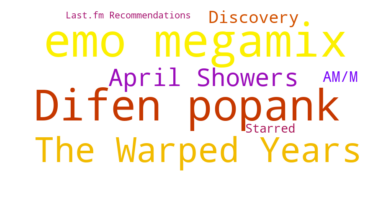

In [26]:
# Plot:

d = pd.DataFrame(get_songs_name([9090])).reset_index()

d.columns = ['index', 'songs']

d_dict = d.set_index('songs').to_dict()['index']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
print(get_user_artist(9090)[0][:1])
print('The Recommended playlist to the artist 9090 are :', get_user_artist(9090)[1][:10])

['55887']
The Recommended playlist to the artist 9090 are : ['Cool Shit', 'Best things ever', 'Metal mix 2.0', 'Star Shpongled Banner', 'Horror Rock', 'spor', 'FRÄÄÄS', 'Korn – Greatest Hits, Vol. 1', 'Limp bizkit', 'Metalli']


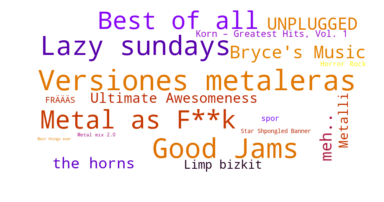

In [28]:
# Plot:

d = pd.DataFrame(get_user_artist(9090)[1][:20]).reset_index()

d.columns = ['index', 'songs']

d_dict = d.set_index('songs').to_dict()['index']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Top 10 recommendations for the particular user's artist's ID.
#### Top 10 recommendations for the particular user's playlists.


In [29]:
def get_top_sorted_users(user_id, data = data, user_artist = user_artist):
    
    neighbors = {}
    for user in user_artist.index:
        neighbors[user] = [np.dot(user_artist.loc[user_id], np.transpose(user_artist.loc[user])), data[data['user_id'] == user].shape[0]]

    # sort by similarity
    neighbors = pd.DataFrame.from_dict(neighbors, orient = 'index').sort_values([0, 1], ascending = False)

    neighbors.drop(user_id, axis = 0, inplace = True) 
    
    neighbors.reset_index(inplace = True)
    
    neighbors.columns = ['neighbors_id', 'similarity', 'num_interactions']
    
    # Return the dataframe specified in the string
    return neighbors


def user_user_recs_part2(user_id, num = 10):
    
    user_listened_ids = get_user_artist(user_id, user_artist)[0]
    neighbors = get_top_sorted_users(user_id, data, user_artist)

    recs = []
    
    for user in neighbors.neighbors_id.values:
    
        sim_user_id = get_user_artist(user, user_artist)[0]
        
        recs_to_add = np.setdiff1d(sim_user_id, user_listened_ids)
        recs_to_add = np.setdiff1d(recs_to_add, recs)
                
        recs.extend(recs_to_add)
        
        if len(recs) >= num:
            break
    
    recs = recs[:num]
    rec_names = get_songs_name(recs, data)
    
    return recs, rec_names[:num]

In [30]:
# Quick spot check:

rec_ids, rec_names = user_user_recs_part2(1400, 10)

print("The top 10 recommendations for user_id 14000, are the following artists ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user_id 14000, are the following playlists names:")
print(rec_names)

The top 10 recommendations for user_id 14000, are the following artists ids:
['10020', '10026', '10075', '1009', '10103', '1012', '10166', '10365', '1037', '10481']

The top 10 recommendations for user_id 14000, are the following playlists names:
['After Work', '90s PARTY', 'Loved tracks - Last.fm', 'Spakolemos House Mix', 'January 2012', 'Star Shpongled Banner', 'Power', 'To listen to part 2', 'Chidie', 'Massive Attack — Protection']


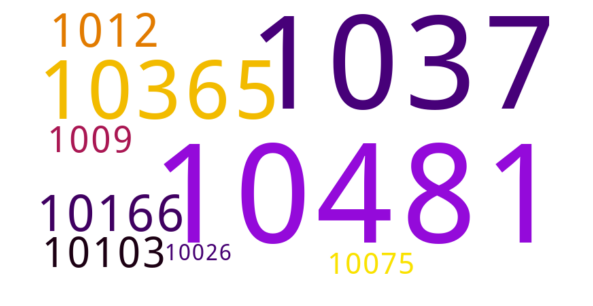

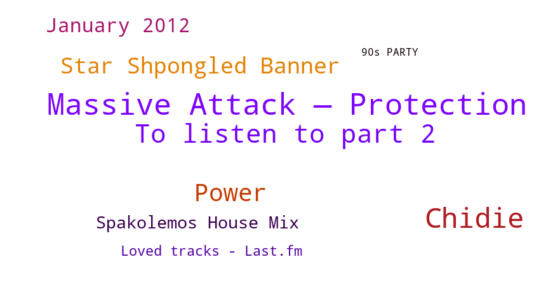

In [31]:
# Plot:

plt.figure(figsize = [20,5])
plt.subplot(1,1,1)

d = pd.DataFrame(rec_ids).reset_index()

d.columns = ['index', 'songs']

d_dict = d.set_index('songs').to_dict()['index']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


plt.figure(figsize = [20,5])
plt.subplot(1,2,2)

d = pd.DataFrame(rec_names).reset_index()

d.columns = ['index', 'songs']

d_dict = d.set_index('songs').to_dict()['index']

genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100).generate_from_frequencies(d_dict)

plt.imshow(genres_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Clustering:

### K_Means Clustering:

#### Top artists to consider:

Total artists to condiser: 1508
     top     share
0      1  0.002863
1     16  0.035104
2    256  0.229546
3   4096  0.663929
4  65536  0.980830


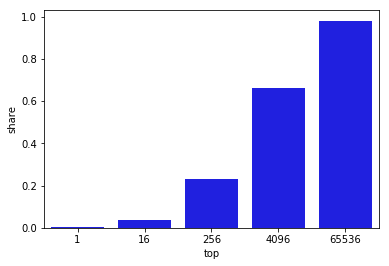

In [32]:
# Plot:

arr = 16 ** np.array(range(5))
i = arr - 1

top_artist = data.groupby('artist_id').count().sort_values(ascending = False, by = 'user_id')
top_artist = top_artist[['user_id']]
top_artist.columns = ['songs']

top_artist['sum'] = top_artist['songs'].cumsum()
top_artist['share'] = top_artist['sum'] / top_artist['songs'].sum()

total_artist = len(top_artist) - (top_artist['share'] > 0.5).sum()
print('Total artists to condiser:', total_artist)

song_list = (top_artist.reset_index().iloc[i][['share']].reset_index().rename(columns = {'index': 'top'}))
                    
song_list['top'] = song_list['top'] + 1
print(song_list.head())

sns.barplot(data = song_list,  x = 'top', y = 'share', color = 'blue');

In [33]:
# Top artist and playlist for clustering:

artist_list = top_artist.reset_index().iloc[:total_artist]['artist_id']
songs_list = data[data.artist_id.isin(artist_list)]

#### User_artist martix for model:

In [34]:
def create_user_artist_matrix(data):
    
    data['interact'] = 1
    data['interact'].apply(lambda ele: 1)
    user_artist_mat = data.groupby(['user_id', 'artist'])['interact'].max().unstack().fillna(0)
    
    return user_artist_mat

user_artist_mat = create_user_artist_matrix(songs_list)

user_artist_mat.head(10)

artist,2 Chainz,2Pac,3 Doors Down,311,3OH!3,5 Seconds Of Summer,50 Cent,A Day To Remember,A Perfect Circle,A Tribe Called Quest,...,Zero 7,Zoé,a-ha,alt-J,blink-182,deadmau5,lostprophets,tUnE-yArDs,will.i.am,Ólafur Arnalds
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fit-Model

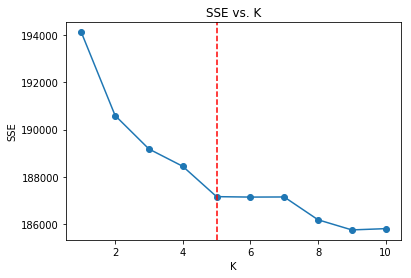

In [35]:
# Fit model:

wcss = []

for ele in range(1,11):
    k = KMeans(n_clusters = ele, init = 'k-means++', random_state = 42)
    k.fit(user_artist_mat)
    wcss.append(k.inertia_)

    
d = [i*100 for i in np.diff(wcss, 2)].index(min([i*100 for i in np.diff(wcss, 2)]))
plt.plot(range(1,11), wcss, marker = 'o')
plt.axvline(d, ls = '--', color = "red", label = "d = "+str(d))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K');

#### Cluster users into k Groups:

In [36]:
# Fit model with appreciate cluster value:

k = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
k.fit(user_artist_mat)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [37]:
# Adding cluster values to dataset:

lables = k.labels_

df_cluster = user_artist_mat.reset_index()[['user_id']]

df_cluster['cluster'] = lables
df_cluster.head()

artist,user_id,cluster
0,1,1
1,2,0
2,3,1
3,4,1
4,5,4


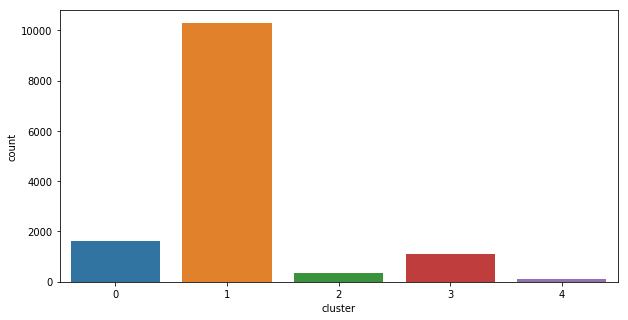

In [38]:
# Cluster distributions:

plt.figure(figsize = (10, 5))
sns.countplot(data = df_cluster, x = 'cluster',  color = 'blue');

#### Top artist in each cluster:

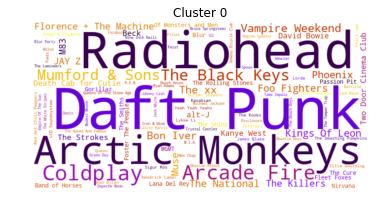

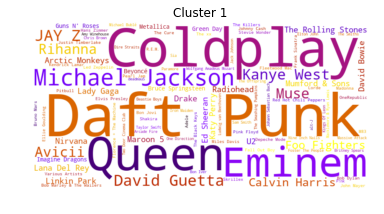

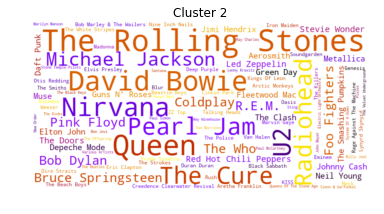

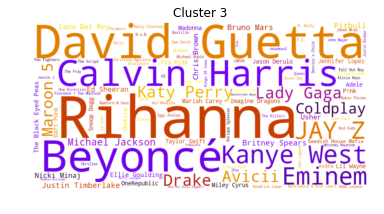

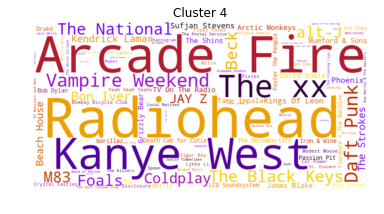

In [39]:
# Plot:

for ele in sorted(df_cluster.cluster.unique()):
    users = df_cluster.loc[df_cluster.cluster == ele, 'user_id']
    cluster_user = user_artist_mat.loc[list(user_artist_mat.reset_index().user_id.isin(users))]

    c = pd.DataFrame(cluster_user.sum() / cluster_user.to_numpy().sum())
    c['artist'] = c.index

    d_dict = c.set_index('artist').to_dict()[0]

    genres_cloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'gnuplot', max_words = 100).generate_from_frequencies(d_dict)

    plt.imshow(genres_cloud, interpolation = 'bilinear')
    plt.title("Cluster " + str(ele))
    plt.axis('off')
    plt.show()

## Matrix Factorization:

#### Split data:

Split scaled Train dataset into:

80% training set.

20% validation set.

In [40]:
# Split data:

train, test = train_test_split(songs_list, test_size = 0.20, random_state = 42)


# train-test Matrix:
def create_test_and_train_user_item(train, test):

    user_item_train = create_user_artist_matrix(train)
    user_item_test = create_user_artist_matrix(test)
    test_idx = list(user_item_test.index)
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(train, test)

In [41]:
# fit SVD on the user_item_train matrix:

u, s, vt = np.linalg.svd(user_item_train) 

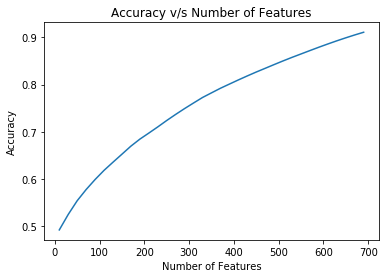

In [42]:
# To check accuracy:

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/songs_list.shape[0]);
plt.xlabel('Number of Features');
plt.ylabel('Accuracy');
plt.title('Accuracy v/s Number of Features');

According to the graph above, as the number of latent feature increases accuracy of the data also increased.

### Conclusion:

One of the biggest problems with this model is that there are almost no metrics to evaluate whether the recommendation is good or bad. 

The two methods are the Collaboration-based filtering approach and the clustering method using K-nearest neighbors approachs were conducted.

These approach of recommender system is very interesting, but in my opinion there are three big problem:

1. Reducing the interaction matrix in '1' if a user interact with an artist and '0' if not is very reductive, it takes a great reduction of information and a large increase in noise.
2. It's very difficult to evaluate the algorithm.
3. The dataset is too simple, a dataset with song's attributes, and an a suitable algorithm will be more accurate, because usually a user, except for a few artist, is more related to the genre than to the artist.